# Interface residue ML prediction. Sixth attempt, add distance and convolve over features of a point(points * features). 

# 20 points and 100 points, higher density during dMaSIF training. Used 100 for sup_sampling and 0.5 for resolution.

Idea is simple: higher density of points. 100 at sup_sampling initializes with a higher point cloud density around atoms. Resolution 0.5 specifies the minimum distance between points at the surface (after initialization).

Using 100 points should have about the same area as 20 points with lower density. Verify manually in pyMol!
20 points should cover a small area compared to what I did before.
This is before using Zander's script to calculate angles to target AA. At the moment I only use angles between target surface points and "binder" AAs.

## Load modules and packages

In [3]:
from sklearn import tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from sklearn import datasets
from sklearn.decomposition import PCA
import random

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

## Load data, standard dictionaries and lists
Also:
- Removes empty columns from One-hot encoded target array. (Some standard residues in dict and list do not occur in dataset)
- Store an int version of One-hot encoded target array.
- Scale input features
- Split in training and test sets

In [6]:
res2num = {"ALA": 0, "ASX": 1, "CYS": 2, "ASP": 3, "GLU": 4, "PHE": 5, "GLY": 6, "HIS": 7,
 "ILE": 8, "LYS": 9, "LEU": 10, "MET": 11, "ASN": 12, "PRO": 13, "GLN": 14,
  "ARG": 15, "SER": 16, "THR": 17, "SEC": 18, "VAL": 19, "TRP": 20, "XAA": 21,
   "TYR": 22, "GLX": 23}

old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS",
 "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN",
  "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA",
   "TYR", "GLX"]

In [20]:
# Load features and targets
X = np.load('../dataset/dense_train_data.npy')
X_old = X
X_20 = X_old[:, 0:560]


y = np.load('../dataset/dense_train_target.npy')
n_obs = y.shape[0]

# Select non zero from old_names using y first
nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
names = []
for i in nonzero_index:
    names.append(old_names[i])
    
# Then remove zero columns from 'y'
y = y[:,~np.all(y == 0, axis = 0)]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_old)
X = X_scaled.reshape(n_obs, 100, 28)

X_small_scaled = scaler.fit_transform(X_small)
X_small = X_small_scaled.reshape(n_obs, 20, 28)

In [21]:
# Just check the ranges of features
feature_count =0
for i in range(X.shape[-1]):
    print(feature_count, np.min(X[:,:,i]), np.max(X[:,:,i]))
    feature_count+=1

0 -5.438737693829469 2.9498201552098138
1 -16.866096881642203 5.223976857663398
2 -5.654350992146541 3.423015454833679
3 -19.236426010146115 6.358782807008987
4 -6.262654342487455 5.2111694452732955
5 -18.469020739255654 11.830376865453045
6 -5.179563896858524 7.5626657900582765
7 -10.239315441131804 17.690018801240868
8 -3.409765892375778 6.708867931923382
9 -6.4956560576408 10.739180551392337
10 -4.501431856202298 5.1350909938690945
11 -4.531717504810575 4.766918399633567
12 -3.8058392260262246 4.059144343372493
13 -4.725631539574924 4.3452310534462635
14 -2.3864240696190815 3.554321767004896
15 -3.9426855112767423 3.4116100634906226
16 -7.094755313319609 3.958199751947529
17 -6.6629336464231175 3.8893417397524437
18 -5.557706531900601 9.0722643600094
19 -5.116402118308965 7.010125443200985
20 -4.306942995496009 5.790379037706982
21 -4.979150581883489 6.40573198707762
22 -3.5016938381311213 9.290378429538826
23 -5.300225981261393 7.9624952183327
24 -0.0 -0.0
25 -1.7557791765788024 0.

In [22]:
# Get integer values from one-hot encoding
y_int = np.array([])
for i in y:
    y_int = np.concatenate((y_int, np.nonzero(i)[0]))

# Save float and unique arrays of y_int
y_float = y_int.astype(np.float32)
unique_y = np.unique(y_float)

In [23]:
# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_float, test_size=0.2, random_state=2)

In [24]:
# Split the data set into training and testing
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
    X_small, y_float, test_size=0.2, random_state=2)

In [26]:
X_temp_train = X_train.reshape(X_train.shape[0],2800)
X_temp_test = X_test.reshape(X_test.shape[0],2800)

Xs_temp_train = X_small_train.reshape(X_small_train.shape[0],560)
Xs_temp_test = X_small_test.reshape(X_small_test.shape[0],560)

## Basic EDA and visualisation
Can a simple tree-based machine learning algorithm predict the residue?

Can PCA or t-SNE already find a separation between data points? I.e., is there something distinguishing the point clouds complementary to residues that does not have to be "learned" during multiple irations?

Furthermore, what how frequently do the respective residue types occur at interfaces? One needs to deal with imbalances in the dataset.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=15, random_state=0, class_weight= "balanced")
clf.fit(X_temp_train, y_train)

y_RF_pred = clf.predict(X_temp_test)

In [34]:
clf_s = RandomForestClassifier(max_depth=15, random_state=0, class_weight= "balanced")
clf_s.fit(Xs_temp_train, y_small_train)

ys_RF_pred = clf_s.predict(Xs_temp_test)

In [35]:
len(np.unique(y_RF_pred))

20

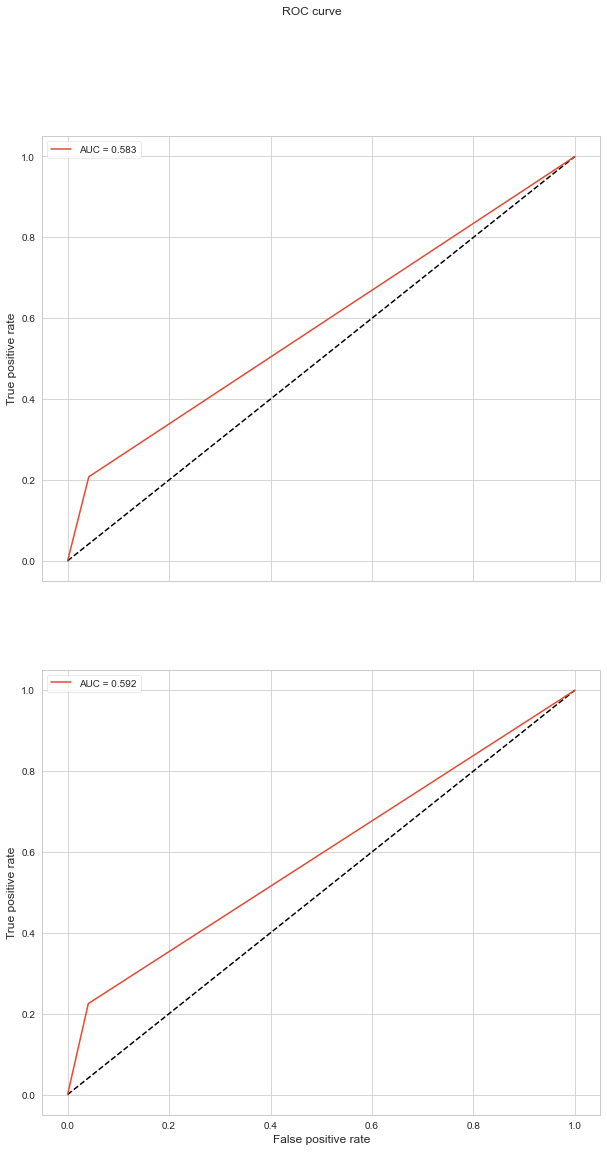

In [90]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

fig, axs = plt.subplots(2, figsize=(10,18))
fig.suptitle('ROC curve')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[1].plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
y_RF_onehot = enc.fit_transform(y_RF_pred[:, np.newaxis]).toarray()

Ys_onehot = enc.fit_transform(y_small_test[:, np.newaxis]).toarray()
ys_RF_onehot = enc.fit_transform(ys_RF_pred[:, np.newaxis]).toarray()

with torch.no_grad():
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_RF_onehot.ravel())
    
with torch.no_grad():
    fprs, tprs, threshold = roc_curve(Ys_onehot.ravel(), ys_RF_onehot.ravel())
    
axs[0].plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
axs[1].plot(fprs, tprs, label='AUC = {:.3f}'.format(auc(fprs, tprs)))

for ax in axs.flat:
    ax.set(xlabel='False positive rate', ylabel='True positive rate')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


axs[0].legend()
axs[1].legend()
sns.set_style("whitegrid")

In [57]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.20444973 0.08471792]


In [58]:
rgb = []
for y in unique_y:
    col = (random.random(), random.random(), random.random())
    rgb.append(col)
colors = rgb

In [59]:
plt.figure()
lw = 2

<Figure size 720x1440 with 0 Axes>

In [60]:
num2res = dict(zip(range(len(names)), names))
y_res_str = pd.Series(y_float).map(lambda x: num2res[x])

'Amino acid counts'

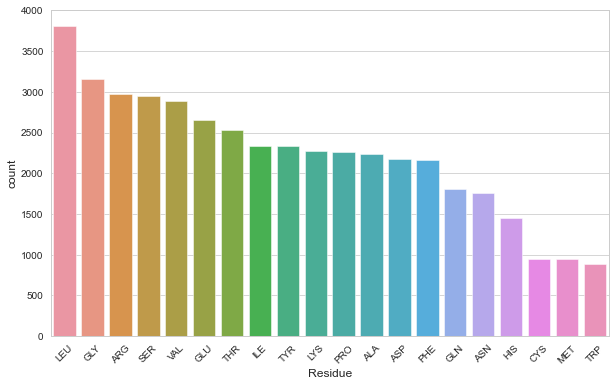

In [92]:
import seaborn as sns
plt.figure(figsize = (10,6))
df = pd.DataFrame(y_res_str)
df.rename(columns={0:'Residue'}, inplace=True)
sns.countplot(x='Residue', data = df, order = y_res_str.value_counts().index)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

g ="Amino acid counts"
g

Text(0.5, 1.0, 'PCA of AA surface dataset')

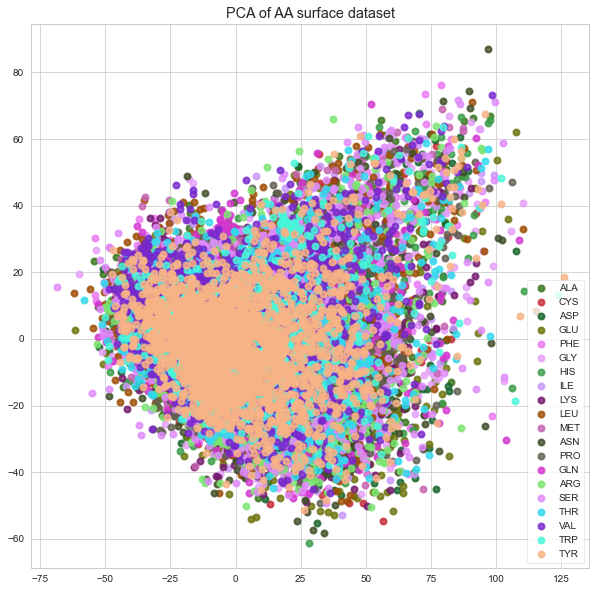

In [66]:
plt.figure(figsize = (10,10))
for color, i, name in zip(colors, unique_y, names[0:20]):
    plt.scatter(X_r[y_int == i, 0], X_r[y_int == i, 1], color = color, alpha=.8, lw=lw,
                label=name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of AA surface dataset')

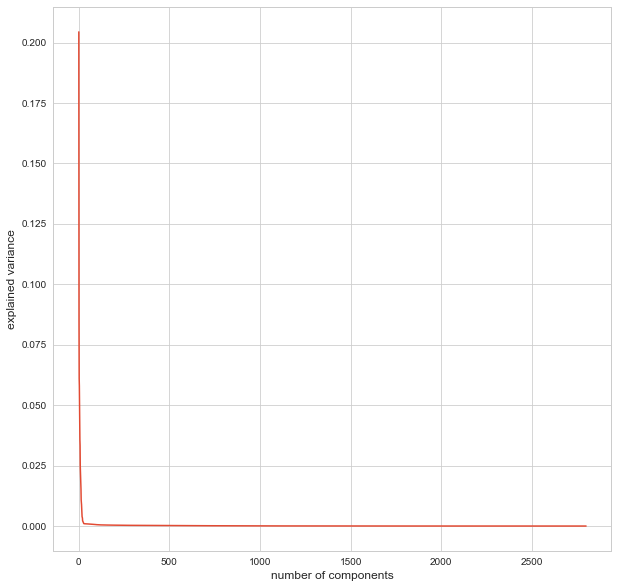

In [70]:
plt.figure(figsize = (8,8))
pca = PCA().fit(X_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance');

In [71]:
print(abs( pca.components_ ))

[[2.73743017e-02 2.53072970e-02 3.55855884e-02 ... 4.31441404e-03
  2.08613560e-02 1.11581250e-03]
 [3.48163574e-02 3.49017617e-02 2.56163406e-02 ... 1.32945601e-03
  1.97276917e-02 1.22773310e-03]
 [3.45247411e-03 2.68420093e-03 1.08938890e-03 ... 4.71281450e-04
  5.79638322e-04 1.34127982e-03]
 ...
 [0.00000000e+00 1.54870973e-16 3.68428104e-16 ... 3.94649591e-17
  6.15826834e-16 1.04083409e-17]
 [0.00000000e+00 1.98720683e-16 3.20537696e-16 ... 1.01915004e-17
  1.69135539e-16 3.03576608e-18]
 [0.00000000e+00 1.15692934e-16 1.84625433e-17 ... 1.06251813e-17
  8.09031661e-16 1.62630326e-17]]


In [72]:
# Add contibution of variables to two PC's and form a single array
contrib_arr = np.add(abs(pca.components_)[0], abs(pca.components_)[1])

In [73]:
contrib_arr.shape

(2800,)

In [83]:
indices = (-abs(contrib_arr)).argsort()[:500]

In [84]:
(indices < 1400).sum()

316

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

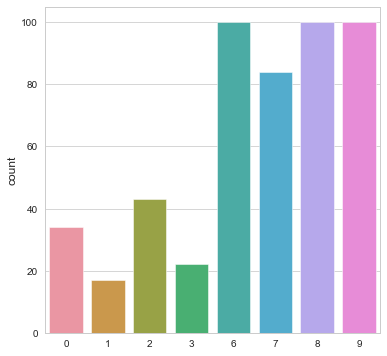

In [94]:
fig, ax = plt.subplots(1, figsize=(6,6))
sns.countplot(indices%28)

<AxesSubplot:xlabel='Ranking', ylabel='Contribution'>

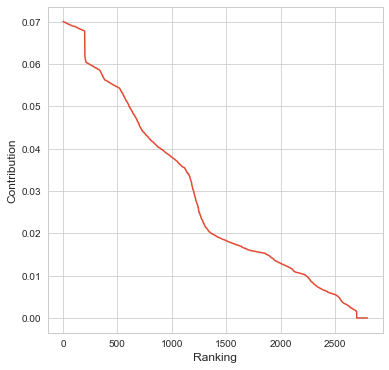

In [96]:
fig, axs = plt.subplots(1, figsize=(6,6))
var_contribution = abs(np.sort(-contrib_arr))
var_pca_df = pd.DataFrame(zip(range(len(var_contribution)), var_contribution))
var_pca_df = var_pca_df.rename(columns={0:"Ranking",1:"Contribution"})
sns.lineplot(data=var_pca_df, x='Ranking', y='Contribution')

In [105]:
X_train.shape

torch.Size([35637, 100, 28])

## Code for 100 points

In [97]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [112]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.layer2 = nn.Linear(100, 20)
        self.drop_layer = nn.Dropout(p=0.5)
        self.layer3 = nn.Linear(1000, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = x.view(-1,50*20)
        x = self.drop_layer(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [113]:
class_sample_count = np.unique(y_train, return_counts=True)[1]
weight = 1. / class_sample_count
res_weight = Variable(torch.from_numpy(weight)).float()

In [114]:
res_weight

tensor([0.0006, 0.0013, 0.0006, 0.0005, 0.0006, 0.0004, 0.0009, 0.0005, 0.0005,
        0.0003, 0.0014, 0.0007, 0.0006, 0.0007, 0.0004, 0.0004, 0.0005, 0.0004,
        0.0014, 0.0005])

In [115]:
model     = Model(X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

Model(
  (layer1): Conv1d(28, 50, kernel_size=(1,), stride=(1,))
  (layer2): Linear(in_features=100, out_features=20, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=1000, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=20, bias=True)
)

In [110]:
import torch.nn.functional as F
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

TypeError: expected np.ndarray (got Tensor)

In [116]:
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 100/100 [08:04<00:00,  4.84s/it]


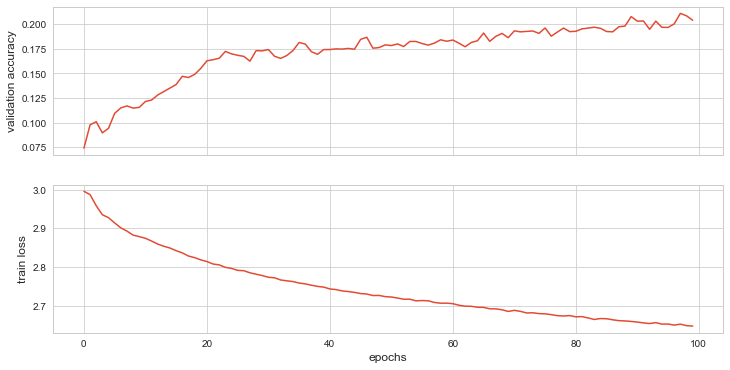

In [117]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs");

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


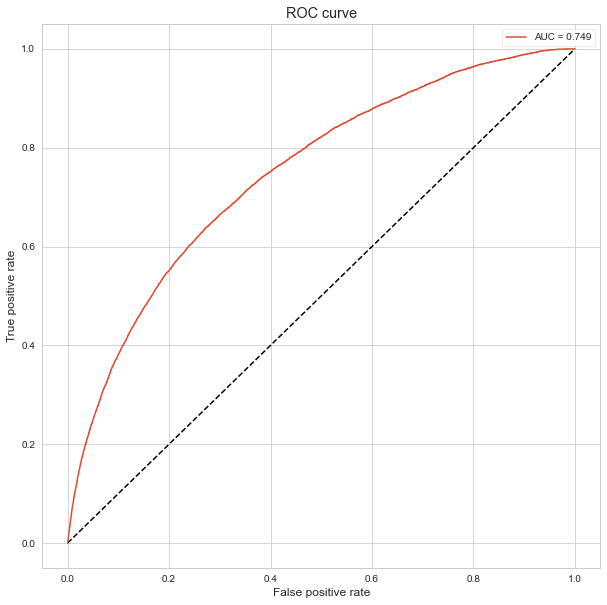

In [118]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

In [119]:
len(np.unique(y_test))

20

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anacond

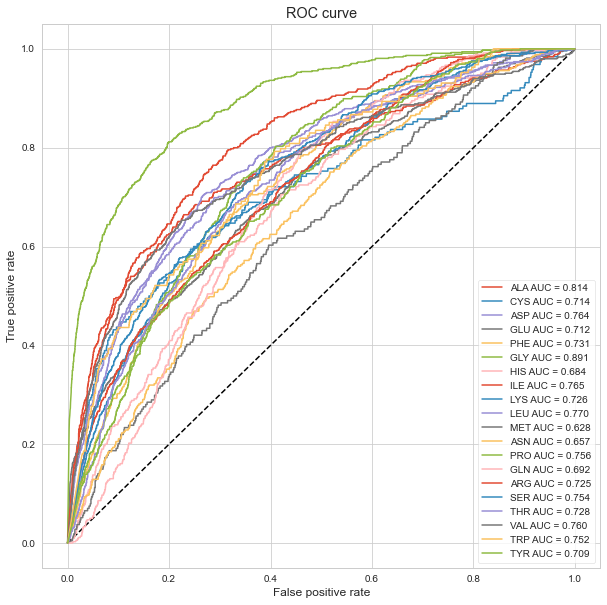

In [120]:
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_test))):
    
    with torch.no_grad():
        y_pre = (model(X_test)[y_test == i]).numpy()
        Y_one = Y_onehot[y_test == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

## 2021.10.26 This model gave the best results yet! See how it does with less points later on

In [135]:
np.amin(np.amax(y_pred, axis=1))

0.32513592

In [122]:
y_pred_max =np.zeros((len(y_pred),len(y_pred[0])))
for count,i in enumerate(y_pred):
    y_pred_max[count, np.argmax(i)] = 1

In [123]:
# One-hot to int
def onehot_int(one_hot):
    y_int = np.array([])
    for i in one_hot:
        y_int = np.concatenate((y_int, np.nonzero(i)[0]))
    return y_int

In [124]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(onehot_int(Y_onehot), onehot_int(y_pred_max))

In [208]:
norm_cm = cm/cm.sum(axis =1,keepdims=True)

In [212]:
norm_cm =norm_cm*100

In [213]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(14, 14))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    plt.close

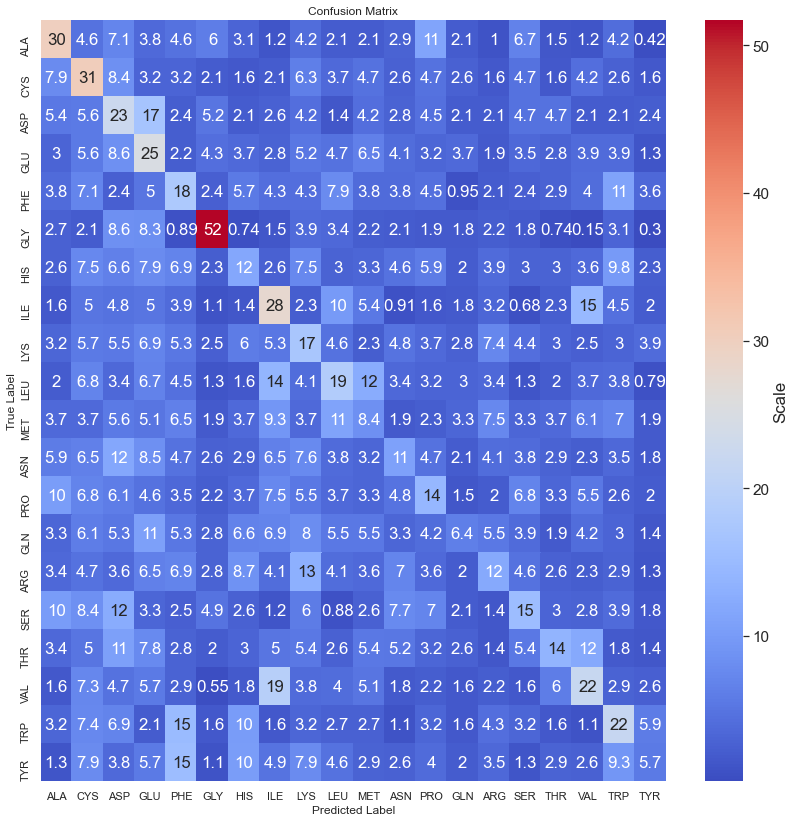

In [214]:
plot_confusion_matrix(norm_cm, names)

## Code for 20 points

In [216]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.layer2 = nn.Linear(20, 20)
        self.drop_layer = nn.Dropout(p=0.5)
        self.layer3 = nn.Linear(1000, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = x.view(-1,50*20)
        x = self.drop_layer(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [217]:
model     = Model(X_small_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
model

Model(
  (layer1): Conv1d(28, 50, kernel_size=(1,), stride=(1,))
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=1000, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=20, bias=True)
)

In [220]:
import torch.nn.functional as F
import tqdm

EPOCHS  = 100
X_small_train = Variable(torch.from_numpy(X_small_train)).float()
y_small_train = Variable(torch.from_numpy(y_small_train)).long()
X_small_test  = Variable(torch.from_numpy(X_small_test)).float()
y_small_test  = Variable(torch.from_numpy(y_small_test)).long()

TypeError: expected np.ndarray (got Tensor)

In [221]:
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_small_pred = model(X_small_train)
    loss = loss_fn(y_small_pred, y_small_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_small_pred = model(X_small_test)
        correct = (torch.argmax(y_small_pred, dim=1) == y_small_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


''

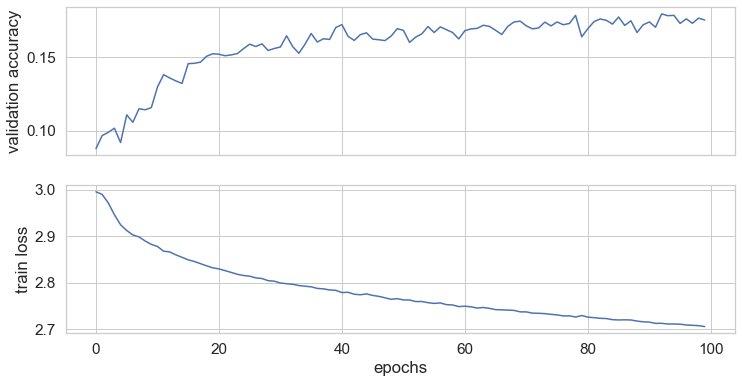

In [224]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
sns.set_style("whitegrid")
ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("train loss")
ax2.set_xlabel("epochs")
;

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


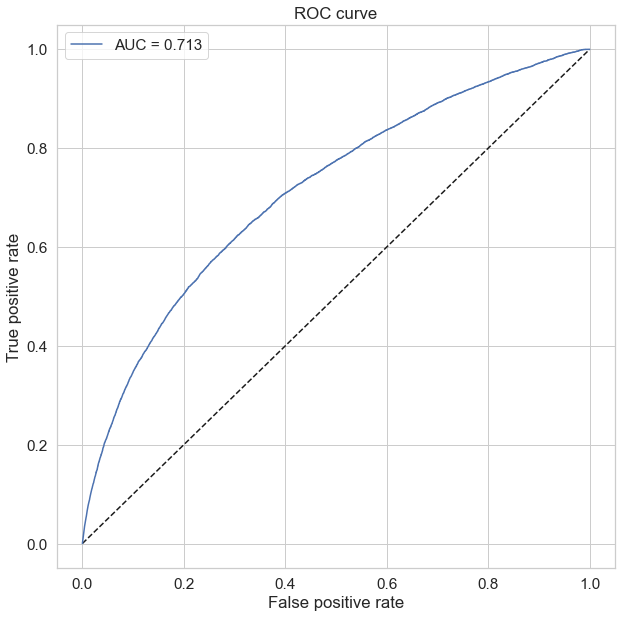

In [225]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_small_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_small_pred = model(X_small_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_small_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();

/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/maxjansen/anacond

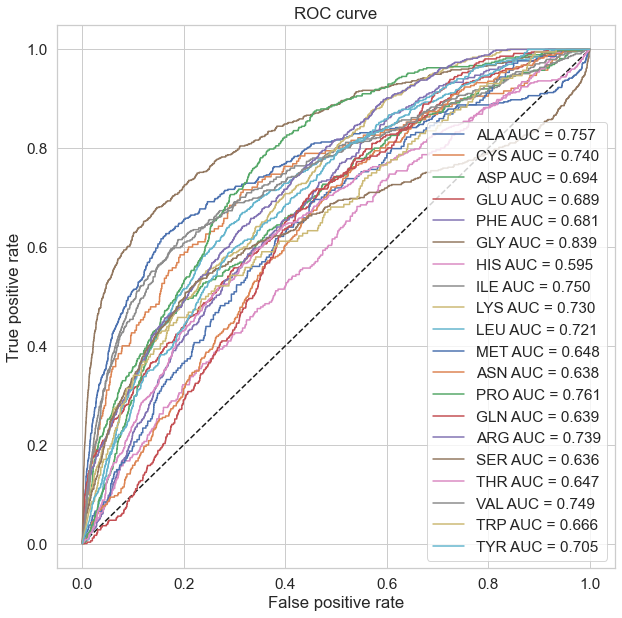

In [227]:
# Do a ROC plot for each amino acid
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_small_test[:, np.newaxis]).toarray()
for i in range(len(np.unique(y_small_test))):
    
    with torch.no_grad():
        y_pre = (model(X_small_test)[y_small_test == i]).numpy()
        Y_one = Y_onehot[y_small_test == i]
        fpr, tpr, threshold = roc_curve(Y_one.ravel(), y_pre.ravel())
    
    plt.plot(fpr, tpr, label=names[i] + ' AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();